# Mapping lineage-traced single-cells across time points

This tutorial presents the standard pipeline for mapping cells across time-points utilising lineage-tracing information
using the moscot solver :class:`moscot.solvers.time.LineageProblem`.

We exemplify this using simulated dataset currated using TedSim :cite:`pan:22`. TedSim simulates cell division events from root cell to present-day cells, simultaneously generating two data modalities for each cell, gene expression and a lineage barcode.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from moscot.problems.time import LineageProblem
from moscot.datasets import lineage
import moscot.plotting as mpl
import numpy as np

from utils import state_tree_draw, tree_draw, plot_cost
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

## load the data.

This dataset is based on TedSim simulated data :cite:`pan:22`. TedSim simulates cell division events from root cell to present-day cells, simultaneously generating two data modalities for each cell, gene expression and a lineage barcode. <br>
The :attr:`anndata.AnnData.X` entry is based on pre-processing of the counts data consisting of :meth:`scanpy.pp.normalize_total` and :meth:`scanpy.pp.log1p`. The simulation provides us with the `.obsm["barcodes"]`  and the following metadata fields `parent`,`cluster`,`depth`, and `cellID` stored in :attr:`anndata.AnnData.obs`. <br>
The `.obs["time"]` is assigned only to cells at depth `8` and `12`, presenting an early and late time-point respectively. <br>
Similarly `.obsp["cost_matrices"]` contains a the pre-computed barcodes distance cost matrix only for the `8` and `12` depth cells.


In [4]:
adata = lineage()

We can visualize the state tree the cells were sampled from

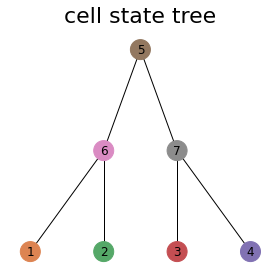

In [5]:
state_tree_draw(state_tree='((t1:2, t2:2):1, (t3:2, t4:2):1):2;')

And the actual simulated tree.<br>
For the purpose of visualizations we focus only the early tree (up to depth 8 in the simulation).

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


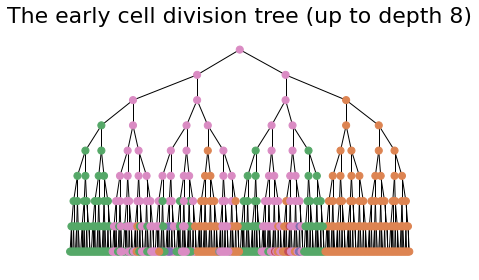

In [6]:
tree_draw(adata, depth=8)

We can see that the cell's state obeys underlying cell state tree. <br>
For each cell the descendants are either of the same state or of a valid descendant based on the cell state tree.

## Set `LineageProblem`

To set a problem we need to specify the following parameters:

 - `time_key` - Time point key in :attr:`anndata.AnnData.obs`.
 - `lineage_attr` - A mapping containing information regarding the cost used for the lineage space, needs to follow the following structure `{"attr": str, "key": str, "tag":"cost", "cost": str}` where:
     * `attr`: a field in the adata object
     * `key`: the key in the field `attr`
     * `tag`: always `cost` (set by default if not provided)
     * `cost`: the cost type, e.g. `barcode_distance`
 - `joint_attr` - The key for the joint space fot the mapping.
     * If `None`, a value is computed based on `callback` using :attr:`anndata.AnnData.X`.
           If callback is not specified PCA is computed.
     * If `str`, it must refer to a key in :attr:`anndata.AnnData.obsm`.
      * If `dict`, the dictionary stores `attr` (attribute of :class:`anndata.AnnData`) and `key`
       (key of :class:`anndata.AnnData` ``['{attr}']``)
 - `policy` - the rule which sets of transport maps are computed given different distributions of cells. 
 - `filter` - the time points used for mapping.

Here we use the `filter` property to focus on depth `8` and `12` and pass the precomputed barcode distances as the `lineage_attr`

We can now visualize the `lineage` cost which is based on barcode distances to get a sense of the structure it captures. <br>
Since cells are ordered by location in the tree a block structure is expected.

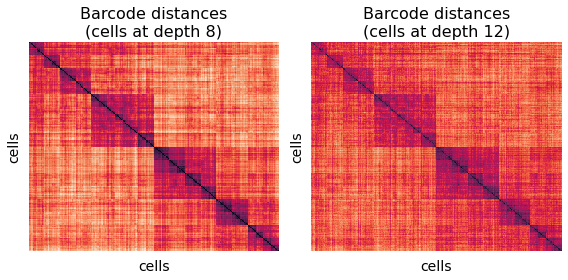

In [9]:
plot_cost(lp)

## Solve the problem

To solve the problem we call :class:`moscot.solvers.time.LineageProblem.solve()` and pass:

- `alpha` - Interpolation parameter between quadratic term (lineage based distance) and linear term (PCA space).
- `epsilon` - Entropic regularizer


In [10]:
lp = lp.solve(alpha=0.99, epsilon=1e-3)

INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(256, 8192)].                                   


## Visualize the cell-state transition map

We evaluate the **cell-transition map** between the different **cell states** assigned in the simulation (visualized above for the early tree).

Recall the underlying cell state tree defines intermediate cell states ($6$ and $7$) and terminal cell states ($1, 2, 3$, and $4$)

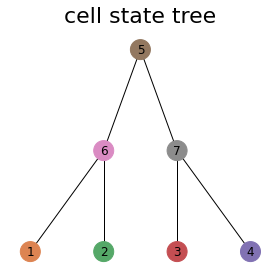

In [11]:
state_tree_draw(state_tree='((t1:2, t2:2):1, (t3:2, t4:2):1):2;')

Given a mapping $\pi_{s, t}$, from source ($s$) cells to target ($t$) cells, the **cell-transition map**, 
$C_{s^{(g)}, t^{(g)}}$ is given by aggregating over source groups ($s^{(g)}$) and target groups ($t^{(g)}$). 

The $i,j$ entry  depicts the mass transferred from the $i$th group in the source population ($s^{(g)}_{i}$) to the $j$th group in the target population ($t^{(g)}_{j}$). Formally this is given by:
$$ C_{s^{(g)}, t^{(g)}}\left(i, j\right) = \sum_{x\in s^{(g)}_{i}} \sum_{y\in t^{(g)}_{j}} \pi_{s, t}\left(x, y\right) $$

We use :class:`moscot.solvers.time.LineageProblem.cell_transition()` to compute the cell-transition map according to the groups defined in `adata.obs["cluster"]` denoting the cell cluster assignment in the original simulation. 

Then we use :class:`moscot.plotting.cell_transition()` to visualize the results

/cs/labs/mornitzan/zoe.piran/venvsc/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/usr/local/python/3.9.7/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


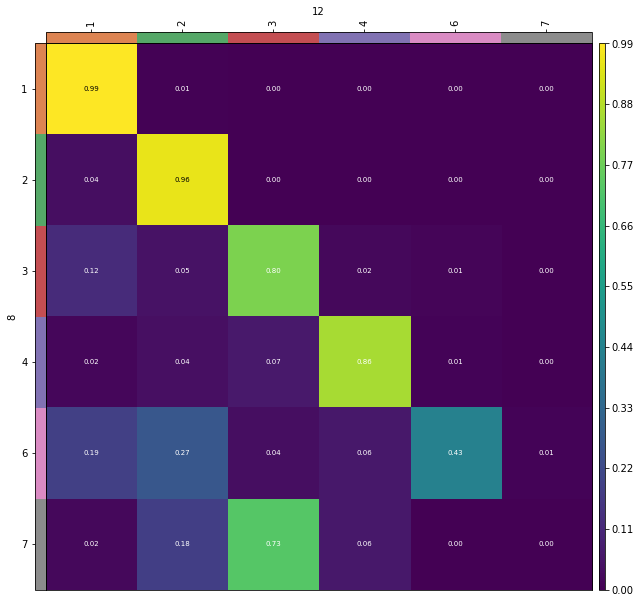

In [12]:
df = lp.cell_transition(
    source=8,
    target=12,
    source_groups="cluster",
    target_groups="cluster",
    forward=True
)
    
mpl.cell_transition(lp, figsize=(8,8))

We see that the terminal cell-states are mapped to themselves and non-terminal sated mapped to valid terminal descendants.

In [ ]:
for key, sol in stp.solutions.items():
    start, end = key
    for col in adata[adata.obs["time"].isin([start])].obs["annotation"].cat.categories:
        adata.obs.loc[adata.obs["time"].isin([end]) ,f"{col}_mapping"] = sol.push(
            np.asarray(adata[adata.obs["time"].isin([start])].obs["annotation"] == col, dtype=int),
        )

We focus on the `Heart` tissue. 

In the first row we plot the spatial locations of the `Heart` cells in each time point. 
In the second row  we show the _push_ output vector projected onto the the spatial coordinates.

In [ ]:
tissue = "Heart"

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(14,8))
for i, tp in enumerate(timepoints):
    sq.pl.spatial_scatter(
        adata[adata.obs["time"].isin([tp])].copy(), 
        color=[f"{tissue}_annotation"],
        title = [f" E{tp} {tissue} cells\n(original annotation)"],
        frameon=False,
        shape=None,
        library_id="hires",
        legend_fontsize = 14,
        ax=axs[0, i]
    )
    if i > 0:
        sq.pl.spatial_scatter(
            adata[adata.obs["time"].isin([tp])].copy(), 
            color=[f"{tissue}_mapping"],
            title = [f"E{timepoints[i-1]} {tissue} cells pushed to E{timepoints[i]} cells"], 
            frameon=False,
            shape=None,
            library_id="hires",
            legend_fontsize = 14,
            cmap="viridis_r",
            colorbar=False,
            ax=axs[1, i]
        )
        
    if i < 2:
        axs[0, i].legend().remove()
    
plt.tight_layout()
axs[1, 0].remove()
plt.show()